In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

Using TensorFlow backend.


In [9]:
BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 75
EMBEDDING = 20

In [10]:
def load_file(file_name):
    with open(file_name, "r") as f:
        lines = f.readlines()
    idx_list = [i + 1 for i, v in enumerate(lines) if v == '\n']
    sentences = []
    words = set()
    pos_tags = set()
    ner_tags = set()
    for i, j in zip([0] + idx_list, idx_list + (
            [len(lines)] if idx_list[-1] != len(lines) else [])):
        sentence = []
        for line in lines[i: j - 1]:
            splitted = line[:-1].split(' ')
            words.add(splitted[0])
            pos_tags.add(splitted[1])
            ner_tags.add(splitted[2])
            sentence.append((splitted[0], splitted[1], splitted[2]))
        sentences.append(sentence)
    return sentences, words, pos_tags, ner_tags

In [11]:
sentences, words, pos_tags, ner_tags = load_file('../../data/CoNLL-2000/train.txt')
n_words, n_tags = len(words), len(ner_tags)


In [12]:
sentences[0]

[('Confidence', 'NN', 'B-NP'),
 ('in', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('pound', 'NN', 'I-NP'),
 ('is', 'VBZ', 'B-VP'),
 ('widely', 'RB', 'I-VP'),
 ('expected', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('take', 'VB', 'I-VP'),
 ('another', 'DT', 'B-NP'),
 ('sharp', 'JJ', 'I-NP'),
 ('dive', 'NN', 'I-NP'),
 ('if', 'IN', 'B-SBAR'),
 ('trade', 'NN', 'B-NP'),
 ('figures', 'NNS', 'I-NP'),
 ('for', 'IN', 'B-PP'),
 ('September', 'NNP', 'B-NP'),
 (',', ',', 'O'),
 ('due', 'JJ', 'B-ADJP'),
 ('for', 'IN', 'B-PP'),
 ('release', 'NN', 'B-NP'),
 ('tomorrow', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('fail', 'VB', 'B-VP'),
 ('to', 'TO', 'I-VP'),
 ('show', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('substantial', 'JJ', 'I-NP'),
 ('improvement', 'NN', 'I-NP'),
 ('from', 'IN', 'B-PP'),
 ('July', 'NNP', 'B-NP'),
 ('and', 'CC', 'I-NP'),
 ('August', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('near-record', 'JJ', 'I-NP'),
 ('deficits', 'NNS', 'I-NP'),
 ('.', '.', 'O')]

In [13]:
ner_tags

{'B-ADJP',
 'B-ADVP',
 'B-CONJP',
 'B-INTJ',
 'B-LST',
 'B-NP',
 'B-PP',
 'B-PRT',
 'B-SBAR',
 'B-UCP',
 'B-VP',
 'I-ADJP',
 'I-ADVP',
 'I-CONJP',
 'I-INTJ',
 'I-NP',
 'I-PP',
 'I-PRT',
 'I-SBAR',
 'I-UCP',
 'I-VP',
 'O'}

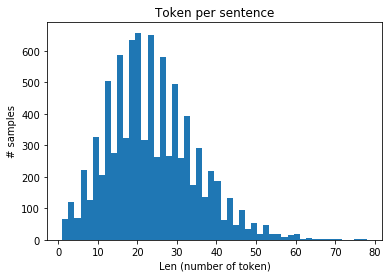

In [14]:
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [15]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(ner_tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
print("The word Confidence is identified by the index: {}".format(word2idx["Confidence"]))
print("The labels I-ADJP is identified by the index: {}".format(tag2idx["I-ADJP"]))

from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])
# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape
print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Confidence is identified by the index: 983
The labels I-ADJP is identified by the index: 6
Raw Sample:  Confidence in the pound is widely expected to take another sharp dive if trade figures for September , due for release tomorrow , fail to show a substantial improvement from July and August 's near-record deficits .
Raw Label:  B-NP B-PP B-NP I-NP B-VP I-VP I-VP I-VP I-VP B-NP I-NP I-NP B-SBAR B-NP I-NP B-PP B-NP O B-ADJP B-PP B-NP B-NP O B-VP I-VP I-VP B-NP I-NP I-NP B-PP B-NP I-NP I-NP B-NP I-NP I-NP O
After processing, sample: [  983 10453 11800  2070  9733 14608 11808  4257  5643  8860 18070 14060
  5530  6974 16850  7745 18367 14835  2826  7745  2600  8294 14835 10500
  4257 10457 16814 15481  2101 10801 13854  9643  9741 10813 17425  8471
  5238     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0   

In [19]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            382480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 23)            1748      
Total params: 417,678
Trainable params: 417,678
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=2)

Train on 7237 samples, validate on 805 samples
Epoch 1/5
 - 17s - loss: 0.6694 - crf_viterbi_accuracy: 0.7779 - val_loss: 0.3286 - val_crf_viterbi_accuracy: 0.8859
Epoch 2/5
 - 16s - loss: 0.2287 - crf_viterbi_accuracy: 0.9333 - val_loss: 0.1568 - val_crf_viterbi_accuracy: 0.9517
Epoch 3/5
 - 16s - loss: 0.1241 - crf_viterbi_accuracy: 0.9607 - val_loss: 0.1083 - val_crf_viterbi_accuracy: 0.9629
Epoch 4/5
 - 16s - loss: 0.0900 - crf_viterbi_accuracy: 0.9697 - val_loss: 0.0884 - val_crf_viterbi_accuracy: 0.9694
Epoch 5/5
 - 16s - loss: 0.0701 - crf_viterbi_accuracy: 0.9744 - val_loss: 0.0788 - val_crf_viterbi_accuracy: 0.9690


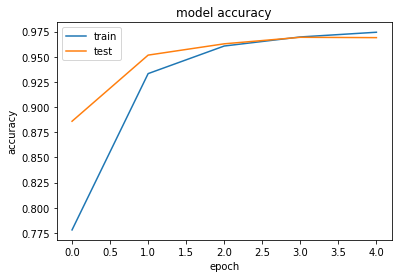

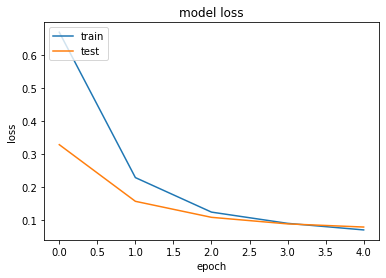

In [27]:
history = model.history

plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [60]:
predictions = np.argmax(model.predict(X_te), axis=2)
test_accuracy = 100 * np.sum(np.array(predictions) == np.argmax(y_te, axis=2)) / (predictions.shape[] * predictions.shape[1])
print('Test accuracy: {:.2f}%'.format(test_accuracy))

Test accuracy: 96.73%
